# Explore `GMRES` Convergence

In [1]:
import numpy  as np
from PyGMRES.gmres import GMRES
from PyGMRES.linop import matmul_a, laplace_1d, laplace_2d, resid
from PyGMRES.linop import laplace_1d_dirichlet, laplace_1d_extrap
from PyGMRES.linop import laplace_2d_dirichlet, laplace_2d_extrap
from PyGMRES.compiler.numba import jit
# from PyGMRES import GMRES, matmul_a, resid, laplace_1d, mk_laplace_2d

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from PyGMRES.compiler import Decorated

decorated = Decorated()
decorated.record

{FunctionDescriptor(module='PyGMRES.gmres', name='GMRES', signature=<Signature (A, b, x0, e, nmax_iter, restart=None, debug=False)>, func=<function GMRES at 0x1307350d0>),
 FunctionDescriptor(module='PyGMRES.gmres', name='update_solution', signature=<Signature (x, y, q)>, func=<function update_solution at 0x113729160>),
 FunctionDescriptor(module='PyGMRES.linop', name='laplace_1d', signature=<Signature (x, i)>, func=<function laplace_1d at 0x13072a310>),
 FunctionDescriptor(module='PyGMRES.linop', name='laplace_1d_constextrap', signature=<Signature (x_in)>, func=<function laplace_1d_constextrap at 0x13072a670>),
 FunctionDescriptor(module='PyGMRES.linop', name='laplace_1d_dirichlet', signature=<Signature (x_in, xlo, xhi)>, func=<function laplace_1d_dirichlet at 0x13072a4c0>),
 FunctionDescriptor(module='PyGMRES.linop', name='laplace_1d_extrap', signature=<Signature (x_in)>, func=<function laplace_1d_extrap at 0x13072a820>),
 FunctionDescriptor(module='PyGMRES.linop', name='laplace_2d',

## Inner-loop (Full GMRES) convergence

Here we'll look at the convergence of full GMRES (non-trunctated, non-restarted). Since the type of problem is important, we'll be looking at both random matrices and 1D laplace operator matrices

### Random Matrices

In [3]:
# (random) test matrix
def mk_A(N):
    M = np.matrix(np.random.randn(N, N))
    @jit(nogil=True, nopython=True)
    def _A(x):
        return matmul_a(M, x)
    return _A

In [4]:
N = 200
A = mk_A(N)

# (random) test problem
xt = np.random.randn(N)
b  = A(xt)
x0 = np.zeros_like(xt)

In order to run non-truncated GMRES => set `e` to 0, do not specify a `restart` and `nmax_iter` to the size of the problem

In [5]:
e = 0
nmax_iter = np.shape(xt)[0]
# Run GMRES
x_rand = GMRES(A, b, x0, e, nmax_iter, debug=True)

Compute the residual (using the `resid` function):

In [6]:
r_rand = resid(A, x_rand, b)

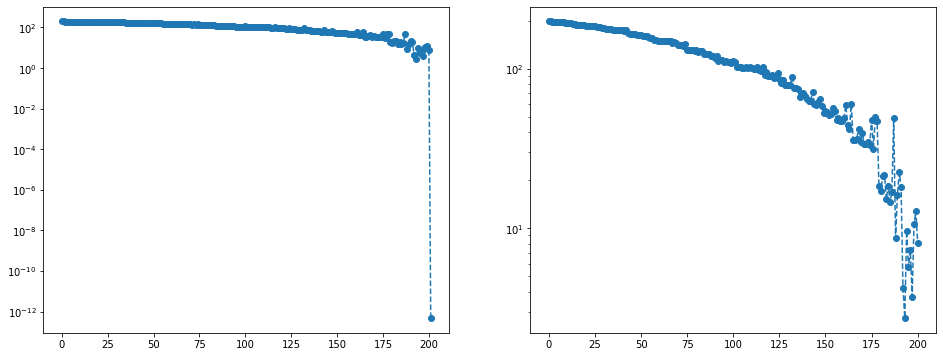

In [7]:
fig, ax = subplots(1,2, figsize=(16,6))

ax[0].semilogy(r_rand, 'o--')
ax[1].semilogy(r_rand[:-1], 'o--')

This is actually really common for random matrices: Only the final step gets anywhere near the solution -- You need to construct the full Krylov space before your iterative solver gets anywhere near the solution. 

This means can be a problem for what we planned to do: when restarting a full-GMRES loop with a solution that is closer to the "right" answer, we still need the full set of iterations to refine the solution:

In [8]:
x_rand_2 = GMRES(A, b, x_rand[-30], e, nmax_iter, debug=True)

In [9]:
r_rand_2 = resid(A, x_rand_2, b)

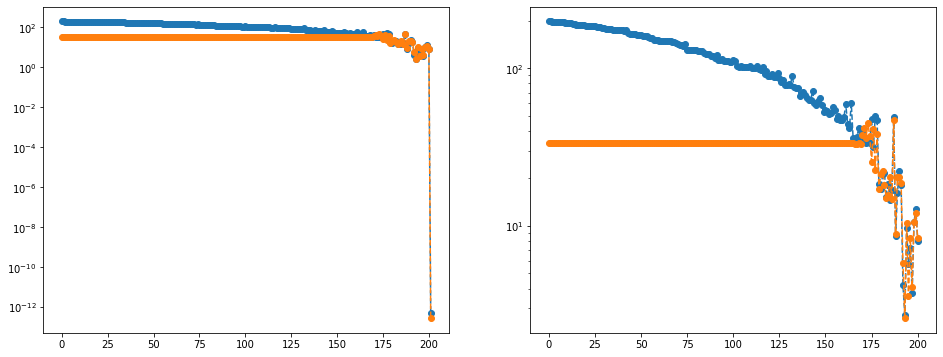

In [10]:
fig, ax = subplots(1,2, figsize=(16,6))

ax[0].semilogy(r_rand, 'o--')
ax[0].semilogy(r_rand_2, 'o--')
ax[1].semilogy(r_rand[:-1], 'o--')
ax[1].semilogy(r_rand_2[:-1], 'o--')

So getting closer to the answer doesn't actually help :(

### 1D Discrete Laplace Matrix

The `laplace_1d` funcion returns a matrix representation of the 1D discrete laplace operator.

In [11]:
N = 200
# (random) test problem
xt = np.random.randn(N)
b  = laplace_1d_extrap(xt)
x0 = np.zeros_like(xt)

In order to run non-truncated GMRES => set `e` to 0, do not specify a `restart` and `nmax_iter` to the size of the problem

In [12]:
e = 0
nmax_iter = x0.shape[0]
# Run GMRES
x_laplace = GMRES(laplace_1d_extrap, b, x0, e, nmax_iter, debug=True)

Compute the residual (using the `resid` function):

In [13]:
r_laplace = resid(laplace_1d_extrap, x_laplace, b)

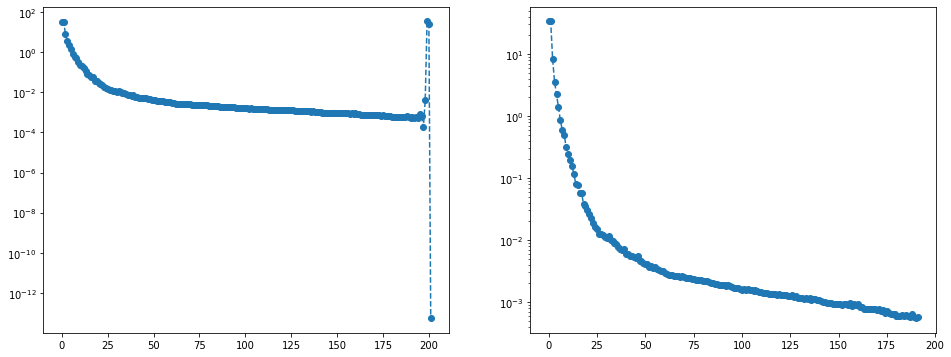

In [14]:
fig, ax = subplots(1,2, figsize=(16,6))

ax[0].semilogy(r_laplace, 'o--')
ax[1].semilogy(r_laplace[:-10], 'o--')

This still has a lot of feature of the random matrix example: mainly that we need the complete Krylov space to get the solution. But this is promising -- each inner loop iteration seems to be contributing "more" to get to the solution. => Even though the random problem (above) was not very encouraging. Let's look at how this converges when we get closer to the real answer

In [15]:
x_laplace_2 = GMRES(
    laplace_1d_extrap, b, x_laplace[-20], e, nmax_iter,
    debug=True
)

In [16]:
r_laplace_2 = resid(laplace_1d_extrap, x_laplace_2, b)

In [17]:
x_laplace_3 = GMRES(
    laplace_1d_extrap, b, x_laplace_2[-20], e, nmax_iter,
    debug=True
)
r_laplace_3 = resid(laplace_1d_extrap, x_laplace_3, b)
x_laplace_4 = GMRES(
    laplace_1d_extrap, b, x_laplace_3[-20], e, nmax_iter,
    debug=True
)
r_laplace_4 = resid(laplace_1d_extrap, x_laplace_4, b)

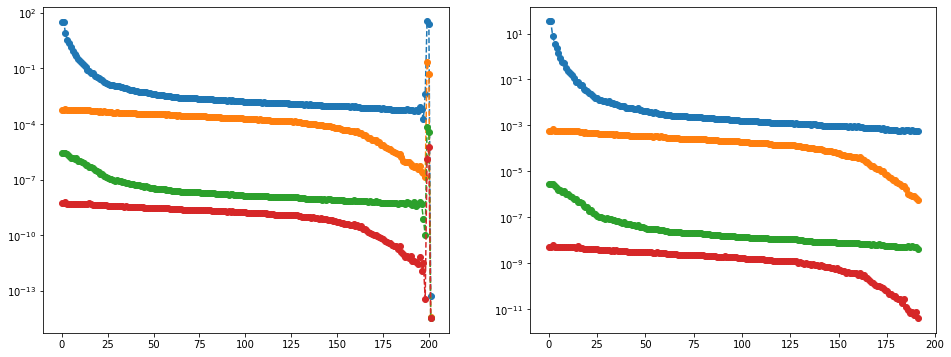

In [18]:
fig, ax = subplots(1,2, figsize=(16,6))

ax[0].semilogy(r_laplace, 'o--')
ax[0].semilogy(r_laplace_2, 'o--')
ax[0].semilogy(r_laplace_3, 'o--')
ax[0].semilogy(r_laplace_4, 'o--')

ax[1].semilogy(r_laplace[:-10], 'o--')
ax[1].semilogy(r_laplace_2[:-10], 'o--')
ax[1].semilogy(r_laplace_3[:-10], 'o--')
ax[1].semilogy(r_laplace_4[:-10], 'o--')

YAY! Unlike the random matrix case, the blue (initial) and orange (continued) lines stay almost parallel => In the case of discrete laplace operators, getting closer to the answer really helps => so the the random matrices are actually much harder than what we're going after

## Outer-loop (Truncated GMRES) convergence with restarts

Now we're going to look at what happens when using restarted and truncated GMRES => don't run the inner loop over the whole problem dimension, and keep refining the solution that way. We need to shoot for this since full GMRES doesn't scale well enough to go to large systems

### Random Matrices

In [19]:
N = 200
A = mk_A(N)
# (random) test problem
xt = np.random.randn(N)
b  = A(xt)
x0 = np.zeros_like(xt)

In order to run restarted + truncated GMRES => specify `restart` with the desired number of restart, and `nmax_iter` to below size of the problem

In [20]:
e = 0
nmax_iter = 100
restart   = 8
# Run GMRES
x_rand   = GMRES(A, b, x0, e, nmax_iter, restart=restart, debug=True)
x_rand_2 = GMRES(A, b, x_rand[80], e, nmax_iter, restart=restart, debug=True)

Compute the residual (using the `resid` function):

In [21]:
r_rand   = resid(A, x_rand, b)
r_rand_2 = resid(A, x_rand_2, b)

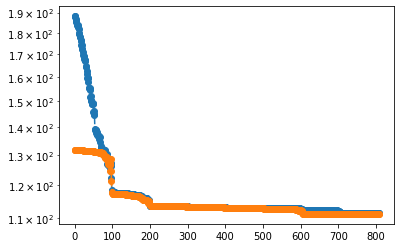

In [22]:
semilogy(r_rand, 'o--')
semilogy(r_rand_2, 'o--')

As expected -- Restarted GRMES "get's stuck" when dealing with large random matrices. Worse still, getting closer won't move to "sticking point" very much => boo!

### 1D Discrete Laplace Matrix

But never fear -- Remember that the `laplace_1d` matrix (i.e. the matrix representation of the 1D discrete laplace operator) doesn't need the full inner loop in the non-restarted problem in the previous section. If these problems are related, then we might not need to fix the "stagnation" problem above -- that didn't stop me from researching restarted GMRES alternatives for 2 days :P

In [23]:
N = 200
# (random) test problem
xt = np.random.randn(N)
b  = laplace_1d_extrap(xt)
x0 = np.zeros_like(xt)

In order to run restarted + truncated GMRES => specify `restart` with the desired number of restart, and `nmax_iter` to below size of the problem

In [24]:
e = 0
nmax_iter = 50
restart   = 64
# Run GMRES
x_laplace   = GMRES(
    laplace_1d_extrap, b, x0, e, nmax_iter,
    restart=restart, debug=True
)
x_laplace_2 = GMRES(
    laplace_1d_extrap, b, x_laplace[-20], e, nmax_iter,
    restart=restart, debug=True
)
x_laplace_3 = GMRES(
    laplace_1d_extrap, b, x_laplace_2[-20], e, nmax_iter,
    restart=restart, debug=True
)

Compute the residual (using the `resid` function):

In [25]:
r_laplace   = resid(laplace_1d_extrap, x_laplace, b)
r_laplace_2 = resid(laplace_1d_extrap, x_laplace_2, b)
r_laplace_3 = resid(laplace_1d_extrap, x_laplace_3, b)

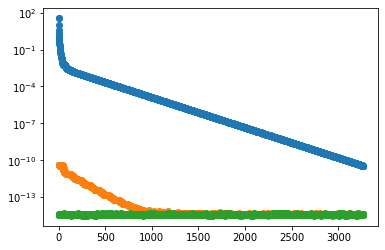

In [26]:
semilogy(r_laplace, 'o--')
semilogy(r_laplace_2, 'o--')
semilogy(r_laplace_3, 'o--')

Hurray - the world is whole again! (Since I've always used GMRES on Laplace-Style problems, I wasn't even aware of the stagnation problem to begin with -- this made me convinced that my implementation problem was faulty) Note how we used a much smaller sub-problme size than in the random case!

### Fun with Tolerances

The fact that we get decent convergence with restarted truncated GMRES means that we can meaningfully use toleratnces: we can train on high-tolerance problems -- and then use a few post-flight iterations (at low tolerance) to refine the result.

In [27]:
e1 = 1e-8
e2 = 1e-10
nmax_iter = 50
restart   = 64
# Run GMRES
x_laplace_e1 = GMRES(
    laplace_1d_extrap, b, x0, e1, nmax_iter,
    restart=restart, debug=True
)
x_laplace_e2 = GMRES(
    laplace_1d_extrap, b, x_laplace_e1[-1], e2, nmax_iter,
    restart=restart, debug=True
)

In [28]:
r_laplace_e1 = resid(laplace_1d_extrap, x_laplace_e1, b)
r_laplace_e2 = resid(laplace_1d_extrap, x_laplace_e2, b)

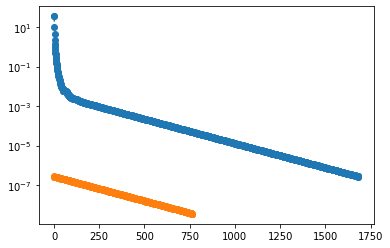

In [29]:
semilogy(r_laplace_e1, 'o--')
semilogy(r_laplace_e2, 'o--')

Note how the second high-accuracy run (orange) took about half the number of steps to refine the result => If we can learn the blue solution (since it's relatively low accuracy, this should be possible with finite data), then we can speed up the time-to-solution considerably. Rejoice.

## Convergence of the 2D Laplacian

We can look at the convergence of the 2D laplacian now -- the spiel is much the same

In [30]:
# use odd dimension because we want to put a point-source in the center.
Nx = 81
Ny = 81

# set up the RHS
b = np.zeros((Nx, Ny))
b[int(Nx/2), int(Ny/2)] = 1
x0 = np.zeros_like(b)

In [31]:
e1 = 1e-8
e2 = 1e-10
# Note: nmax_iter needs to << N[x,y] -- if not, then there is no point restarting
nmax_iter = 10
restart   = 64
# Run GMRES
x_laplace_e1_2d = GMRES(
    laplace_2d_extrap, b, x0, e1, nmax_iter, 
    restart=restart, debug=True
)
x_laplace_e2_2d = GMRES(
    laplace_2d_extrap, b, x_laplace_e1_2d[-1], e2, nmax_iter,
    restart=restart, debug=True
)
r_laplace_e1_2d = resid(laplace_2d_extrap, x_laplace_e1_2d, b)
r_laplace_e2_2d = resid(laplace_2d_extrap, x_laplace_e2_2d, b)

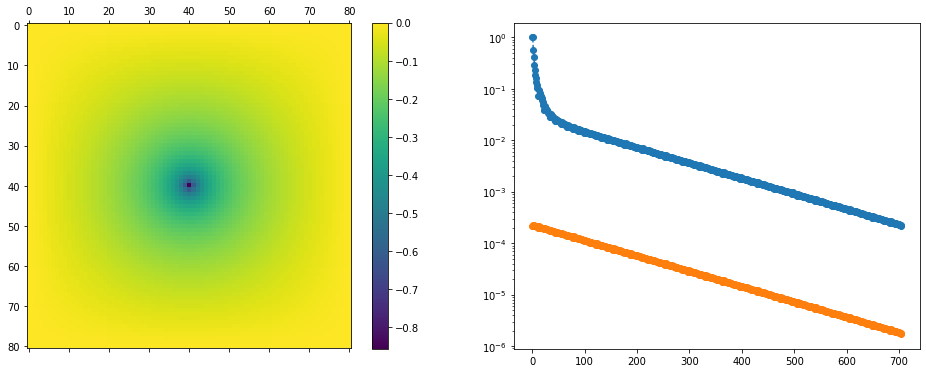

In [32]:
fig, ax = subplots(1, 2, figsize=(16,6))

mat = ax[0].matshow(x_laplace_e2_2d[-1])
fig.colorbar(mat, ax=ax[0])

ax[1].semilogy(r_laplace_e1_2d, '--o')
ax[1].semilogy(r_laplace_e2_2d, '--o')

And we see that the rate of convergence for the 2D problem (orange) is much faster than the 1D problem (blue) -- rejoice!

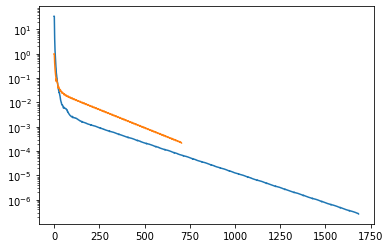

In [33]:
semilogy(r_laplace_e1)
semilogy(r_laplace_e1_2d)